In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import keras
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 1. 데이터 불러오기

* 데이터는 한 시간 간격으로 기록
* 기상 데이터 - 2015-01-01 ~ 2021-04-30 당진 기상관측데이터, 울산 기상관측데이터
* 발전량 데이터 - 2015-01-01 ~ 2021-01-31 수상, 자재창고, 당진, 울산 4개 장소
                                          (ulsan_not_used 열은 삭제하고 진행)

In [345]:
#당진, 울산 기상 관측 데이터
raw_weather_dangjin = pd.read_csv('Solar_Power_mycode/proc_by_yj15-21/dangjin_obs_15_21.csv')
raw_weather_ulsan = pd.read_csv('Solar_Power_mycode/proc_by_yj15-21/ulsan_obs_15_21.csv')

# floating, warehouse, dangjin, ulsan 발전량 데이터
raw_power_dataset = pd.read_csv('Solar_Power_mycode/proc_by_yj15-21/energy_new.csv') 

#### 1.1 기상데이터

In [348]:
print(raw_weather_dangjin.shape, raw_weather_ulsan.shape)
raw_weather_dangjin.tail()

(55488, 8) (55488, 8)


Time   ghi        GHI  Temperature  Humidity        Wind_x  \
55483  2021-04-30 19:00  0.11  30.555558         10.1      84.0 -2.300000e+00   
55484  2021-04-30 20:00  0.00   0.000000          9.7      82.0 -1.221600e+00   
55485  2021-04-30 21:00   NaN   0.000000          9.3      86.0 -3.078181e-01   
55486  2021-04-30 22:00   NaN   0.000000          9.1      90.0  6.120000e-18   
55487  2021-04-30 23:00   NaN   0.000000          8.8      93.0 -3.213938e-01   

             Wind_y  Cloud  
55483 -5.630000e-16    4.0  
55484  4.446262e-01    4.0  
55485 -8.457234e-01    4.0  
55486  1.000000e-01    4.0  
55487  3.830222e-01    4.0

* cos(time) 변수 추가 및 null값이 있는 ghi 열 삭제

In [349]:
cos_time = []
for i in range(raw_weather_dangjin['Time'].shape[0]):
     cos_time.append(np.cos(2*np.pi/24*int(raw_weather_dangjin['Time'][i][-5:-3])))
cos_weather_dangjin = pd.concat([raw_weather_dangjin,pd.DataFrame(cos_time)],axis=1)
cos_weather_ulsan = pd.concat([raw_weather_ulsan,pd.DataFrame(cos_time)],axis=1)
cos_weather_dangjin.rename(columns = {0:'cos(time)'}, inplace=True)
cos_weather_ulsan.rename(columns = {0:'cos(time)'}, inplace=True)

In [350]:
cos_weather_dangjin.head()

Time  ghi  GHI  Temperature  Humidity    Wind_x    Wind_y  \
0  2015-01-01 0:00  NaN  0.0          NaN       NaN -1.812707  4.980371   
1  2015-01-01 1:00  NaN  0.0         -4.4      47.0 -1.846909  5.074340   
2  2015-01-01 2:00  NaN  0.0         -4.6      50.0 -1.675899  4.604494   
3  2015-01-01 3:00  NaN  0.0         -4.7      50.0 -3.985283  4.749476   
4  2015-01-01 4:00  NaN  0.0         -5.0      56.0 -3.213938  3.830222   

   Cloud  cos(time)  
0    3.0   1.000000  
1    3.0   0.965926  
2    3.0   0.866025  
3    3.0   0.707107  
4    3.0   0.500000

In [351]:
cos_weather_ulsan.head()

Time  ghi  GHI  Temperature  Humidity    Wind_x        Wind_y  \
0  2015-01-01 0:00  NaN  0.0          NaN       NaN -6.108002  2.223131e+00   
1  2015-01-01 1:00  NaN  0.0         -1.0      42.0 -4.500000 -1.100000e-15   
2  2015-01-01 2:00  NaN  0.0         -1.3      39.0 -2.185478  2.604551e+00   
3  2015-01-01 3:00  NaN  0.0         -2.5      49.0 -3.213938  3.830222e+00   
4  2015-01-01 4:00  NaN  0.0         -3.3      36.0 -5.826094  2.120525e+00   

   Cloud  cos(time)  
0      1   1.000000  
1      1   0.965926  
2      1   0.866025  
3      1   0.707107  
4      1   0.500000

In [10]:
weather_dangjin = cos_weather_dangjin[[
                             'cos(time)',
                             'GHI',
                             'Temperature',
                             'Humidity',
                             'Wind_x',
                             'Wind_y']]
weather_ulsan = cos_weather_ulsan[[
                             'cos(time)',
                             'GHI',
                             'Temperature',
                             'Humidity',
                             'Wind_x',
                             'Wind_y']]

#### 1.2 발전량 데이터

In [353]:
power_dataset = raw_power_dataset[:]
power_dataset.head()

time  dangjin_floating  dangjin_warehouse  dangjin  \
0  2015-01-01 1:00               0.0                0.0      0.0   
1  2015-01-01 2:00               0.0                0.0      0.0   
2  2015-01-01 3:00               0.0                0.0      0.0   
3  2015-01-01 4:00               0.0                0.0      0.0   
4  2015-01-01 5:00               0.0                0.0      0.0   

   ulsan_not_used  ulsan  
0             NaN    NaN  
1             NaN    NaN  
2             NaN    NaN  
3             NaN    NaN  
4             NaN    NaN

* 데이터 분포 시각화
* null 값이 드문드문 보임
* 당진, 울산 일사량 분포 이상 -> 당진은 구간을 나눠 MinMax 진행, 울산은 별다른 조치 x

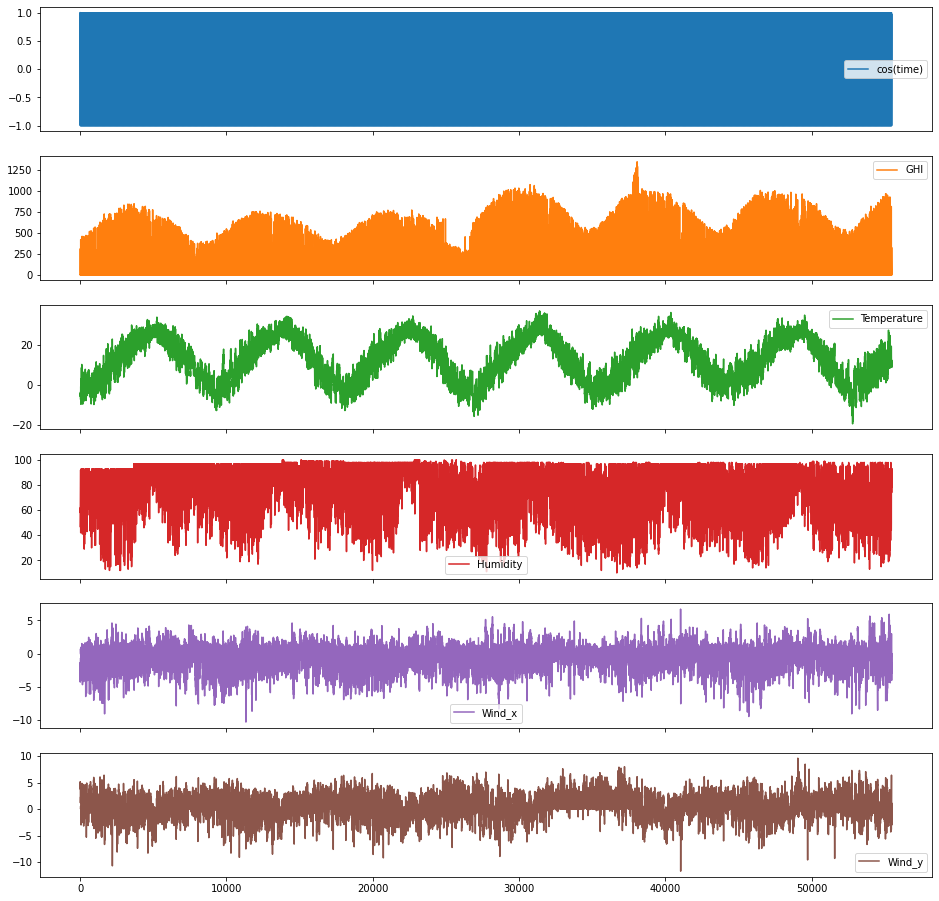

In [13]:
weather_dangjin.plot(subplots=True, figsize=(16, 16));

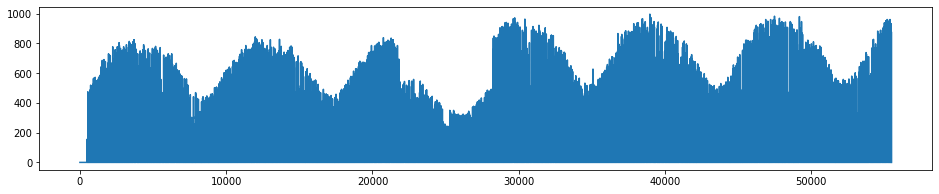

In [14]:
weather_ulsan['GHI'].plot(figsize=(16,3));

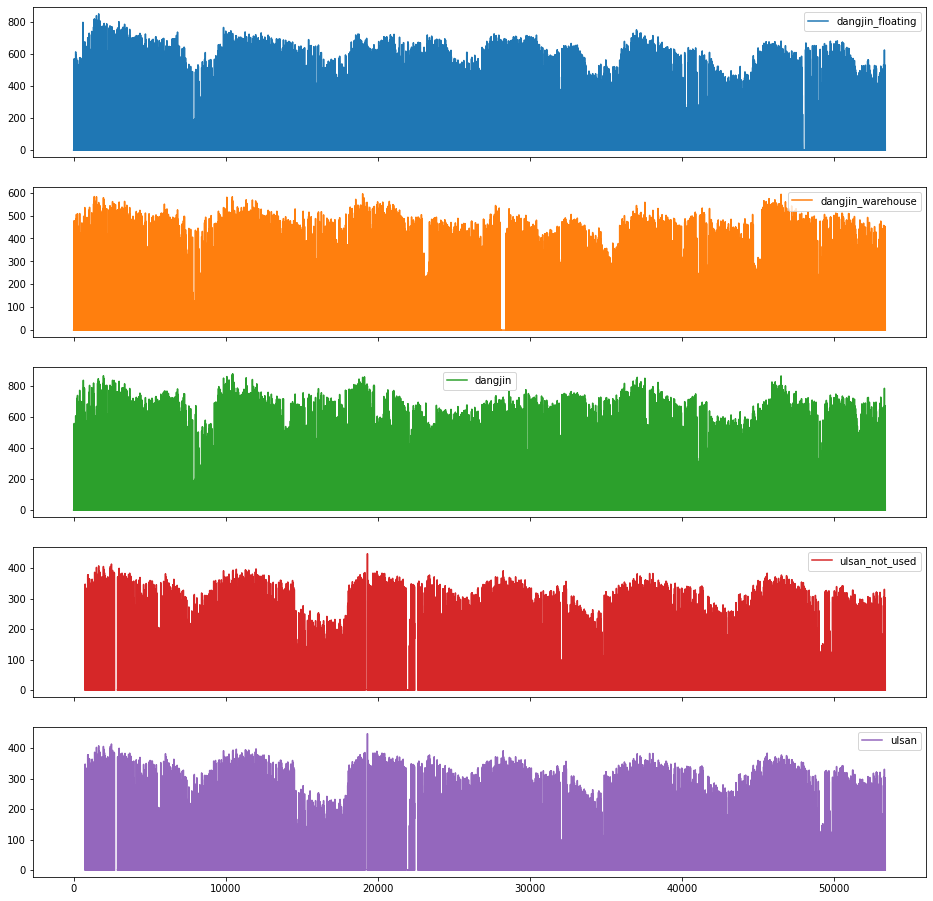

In [15]:
power_dataset.plot(subplots=True, figsize=(16,16));

* 이상치 제거 및 결측치 채워넣기

In [18]:
#1000이상인 일사량을 이상치로 보고 null로 대체
for i in range(len(weather_dangjin)):
    if weather_dangjin['GHI'][i] > 1000:
        weather_dangjin['GHI'][i] = np.nan;

In [20]:
power_dataset = power_dataset.drop(['ulsan_not_used','time'], axis=1)

In [21]:
# null 값들을 K-Nearest Neighbor로 값을 채워줌
from sklearn.impute import KNNImputer
from numpy import isnan

imputer = KNNImputer()
imputer.fit(weather_dangjin.values)
imp_weather_dangjin = imputer.transform(weather_dangjin.values)

imputer.fit(weather_ulsan.values)
imp_weather_ulsan = imputer.transform(weather_ulsan.values)

imputer.fit(power_dataset.values)
proc_power_dataset = imputer.transform(power_dataset.values)

print("데이터 내에 존재하는 NaN의 갯수:", sum(isnan(imp_weather_dangjin).flatten()))
print("데이터 내에 존재하는 NaN의 갯수:", sum(isnan(imp_weather_ulsan).flatten()))
print("데이터 내에 존재하는 NaN의 갯수:", sum(isnan(proc_power_dataset).flatten()))

데이터 내에 존재하는 NaN의 갯수: 0
데이터 내에 존재하는 NaN의 갯수: 0
데이터 내에 존재하는 NaN의 갯수: 0


In [22]:
bound_for_scaler = np.where(raw_weather_dangjin['Time']=='2018-01-01 0:00')[0][0]

In [23]:
imp_weather_dangjin_1 = imp_weather_dangjin[bound_for_scaler:]
imp_weather_dangjin_2 = imp_weather_dangjin[:bound_for_scaler]

In [24]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import scipy as sp
import scipy.stats
scaler = MinMaxScaler()
scaler.fit(imp_weather_dangjin_1)
imp_weather_dangjin_1_scaled = scaler.transform(imp_weather_dangjin_1)
# 당진만 2개로 쪼개서 각각 스케일링
scaler.fit(imp_weather_dangjin_2)
imp_weather_dangjin_2_scaled = scaler.transform(imp_weather_dangjin_2)

scaler.fit(imp_weather_ulsan)
imp_weather_ulsan_scaled = scaler.transform(imp_weather_ulsan)

imp_weather_dangjin_scaled = pd.concat([pd.DataFrame(imp_weather_dangjin_2_scaled),
                                        pd.DataFrame(imp_weather_dangjin_1_scaled)], axis =0)

proc_weather_dangjin = pd.DataFrame(data = np.array(imp_weather_dangjin_scaled),
                                 columns=['cos(time)',
                                         'GHI',
                                         'Temperature',
                                         'Humidity',
                                         'Wind_x',
                                         'Wind_y'])
proc_weather_ulsan = pd.DataFrame(data=imp_weather_ulsan_scaled, 
                                 columns=['cos(time)',
                                         'GHI',
                                         'Temperature',
                                         'Humidity',
                                         'Wind_x',
                                         'Wind_y'])


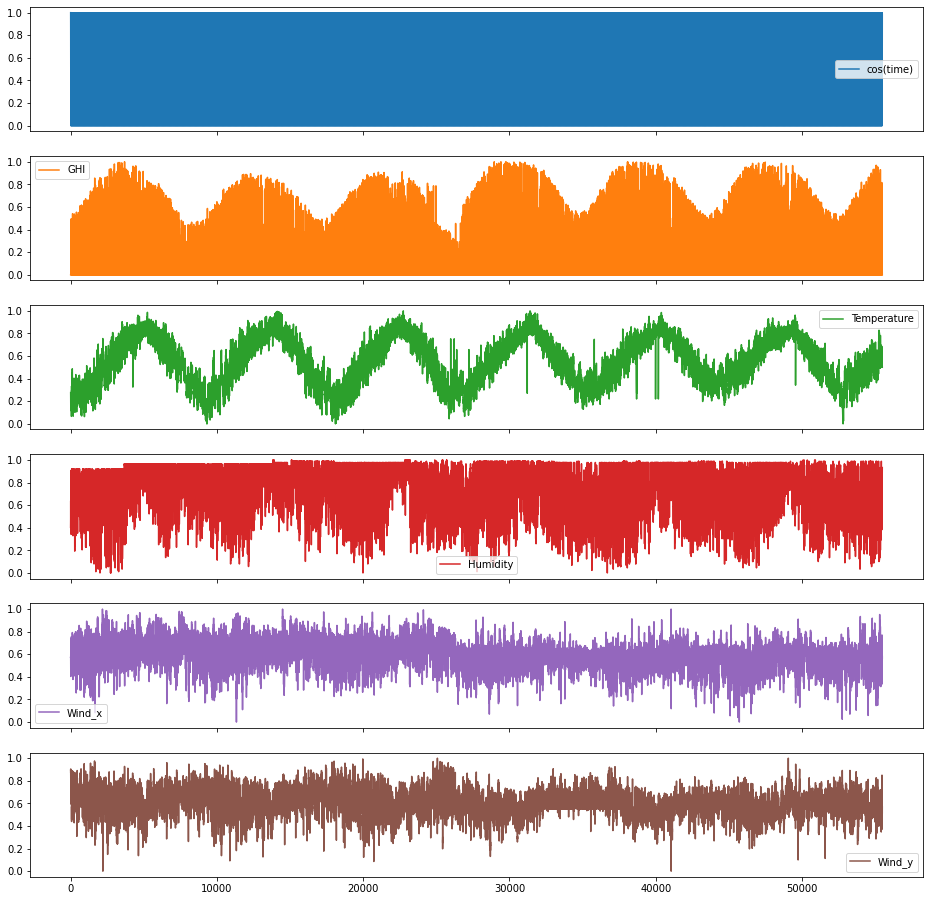

In [25]:
proc_weather_dangjin.plot(subplots=True, figsize=(16,16));

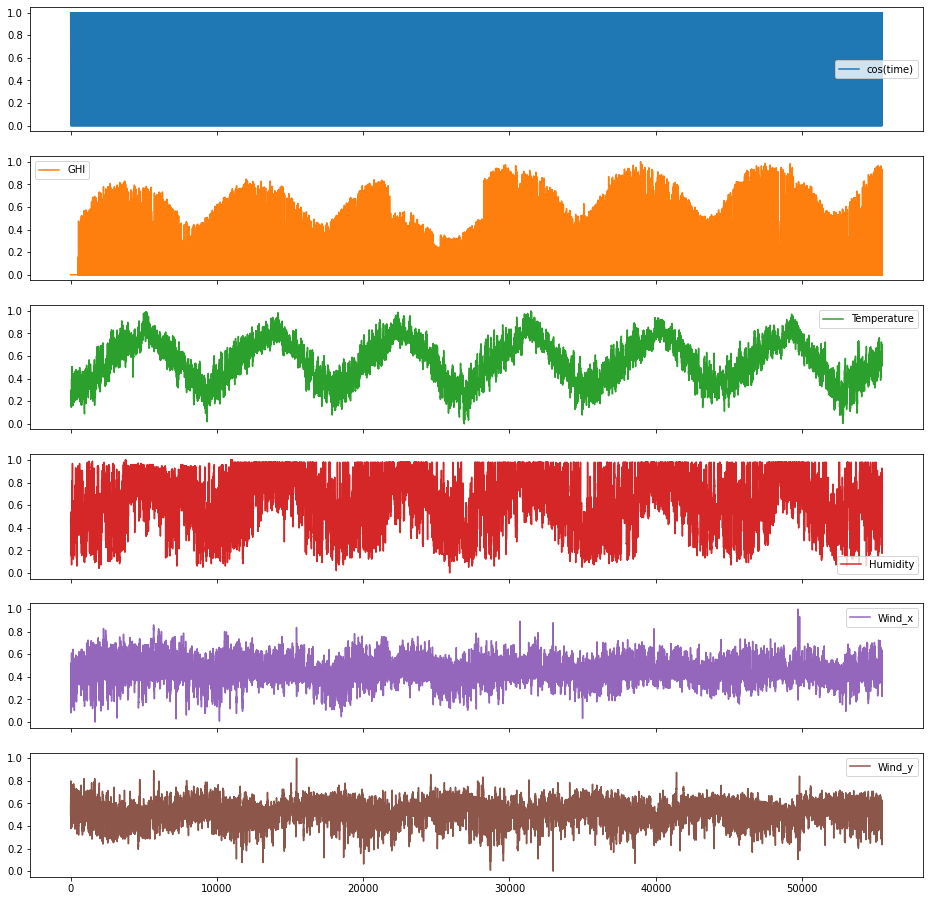

In [26]:
proc_weather_ulsan.plot(subplots=True, figsize=(16,16));

In [27]:
proc_power_dataset = pd.DataFrame(power_dataset)

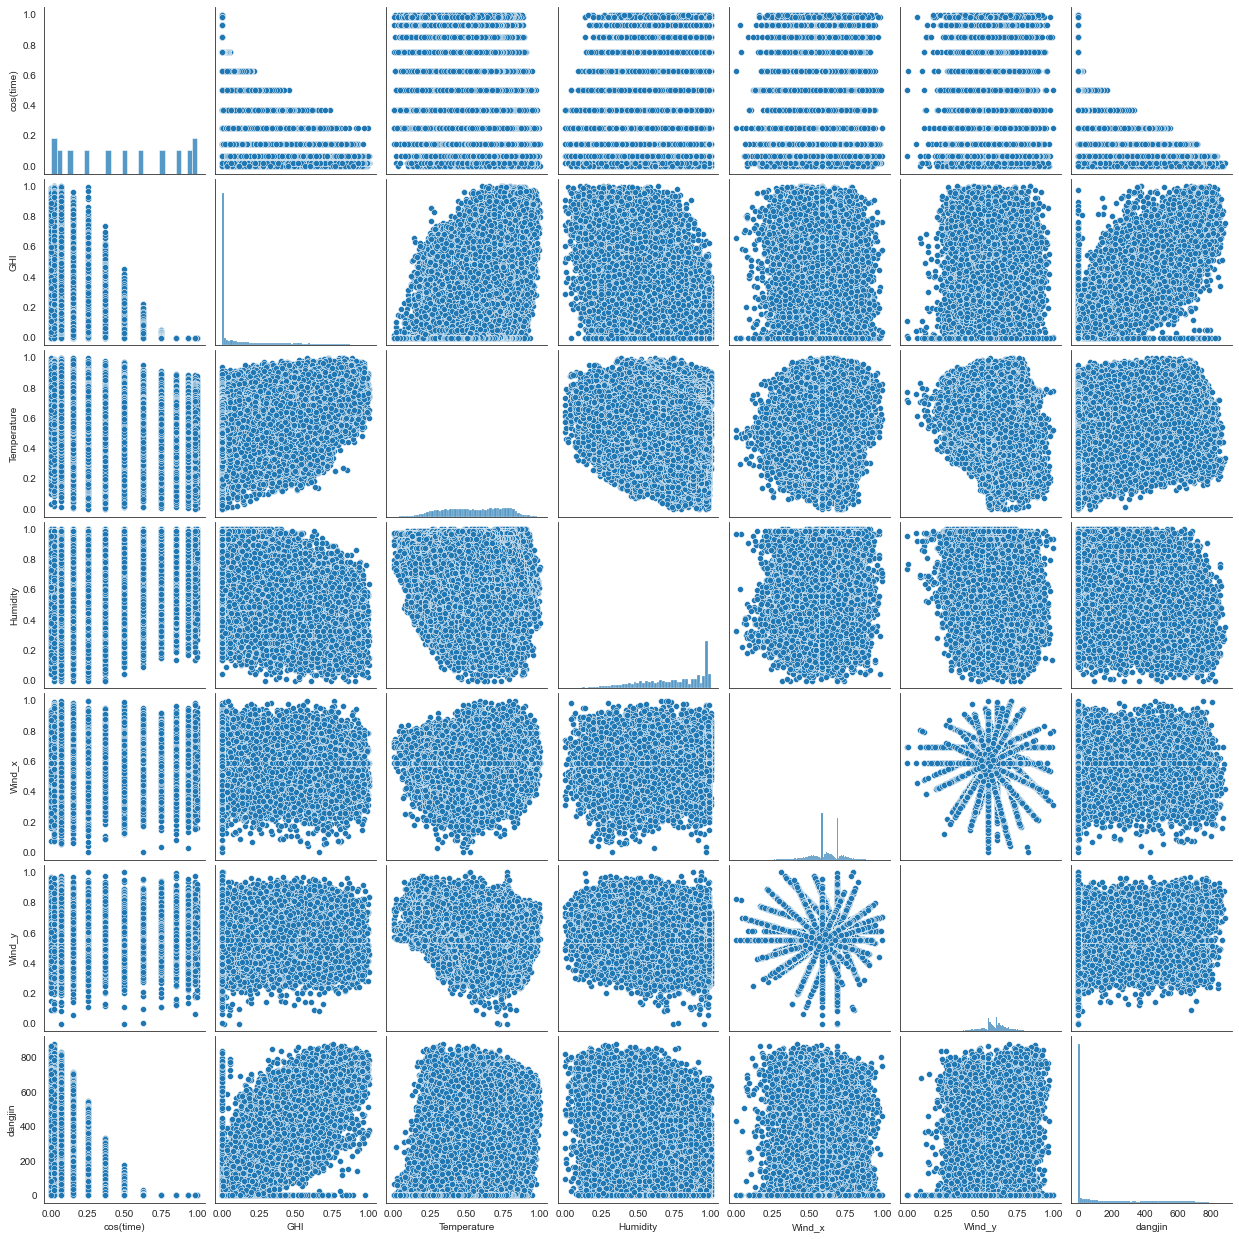

In [28]:
import seaborn as sns
sns.set_style("white")
sns.pairplot(pd.concat([proc_weather_dangjin[['cos(time)',
                                         'GHI',
                                         'Temperature',
                                         'Humidity',
                                         'Wind_x',
                                         'Wind_y']], proc_power_dataset['dangjin']],
                                          axis=1))


In [29]:
proc_power_dataset.rename(columns = {0:'dangjin_floating',
                                     1:'dangjin_warehouse',
                                     2:'dangjin',
                                     3:'ulsan'}, inplace = True)

In [83]:
temp_dataset_dangjin = pd.concat([proc_weather_dangjin,
                             raw_weather_dangjin['Cloud'],
                             proc_power_dataset.drop('ulsan', axis=1)],axis=1)
temp_dataset_ulsan = pd.concat([proc_weather_ulsan,
                             raw_weather_dangjin['Cloud'],
                             proc_power_dataset['ulsan']],axis=1)

imputer.fit(temp_dataset_dangjin.values)
final_dataset_dangjin = imputer.transform(temp_dataset_dangjin.values)

imputer.fit(temp_dataset_ulsan.values)
final_dataset_ulsan = imputer.transform(temp_dataset_ulsan.values)

In [86]:
final_dataset_dangjin = pd.DataFrame(final_dataset_dangjin, columns = temp_dataset_dangjin.columns)
final_dataset_ulsan = pd.DataFrame(final_dataset_ulsan, columns = temp_dataset_ulsan.columns)

In [88]:
print("데이터 내에 존재하는 NaN의 갯수:", sum(isnan(np.array(final_dataset_ulsan)).flatten()))

데이터 내에 존재하는 NaN의 갯수: 0


## 2. 모델링 및 학습

In [53]:
from sklearn.model_selection import train_test_split

In [97]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(20,20))

    plt.subplot(2,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MAE]')
    plt.plot(hist['epoch'], hist['mae'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],label = 'Val Error')
    plt.ylim([0,150])
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [MSE]')
    plt.plot(hist['epoch'], hist['mse'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],label = 'Val Error')
    plt.ylim([0,80])
    plt.legend()
    plt.show()

In [96]:
from keras import layers
def build_model(x_train):
    model = keras.Sequential([
                            layers.Dense(256, activation='relu', input_shape=[len(x_train.keys())]),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(64, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(32, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(1)
                            ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mae','mse'])
    return model

In [50]:
# 이 셀은 cloud 별로 나누려다 실패한 셀.... 재코딩 필요! 
def train_each_cloud(final_dataset_dangjin, final_dataset_ulsan, region):
    dangjin_start = np.where(raw_weather_dangjin['Time'] == '2015-02-01 0:00')[0][0]
    dangjin_bound = np.where(raw_weather_dangjin['Time'] == '2020-01-01 0:00')[0][0]
    dangjin_end = np.where(raw_weather_dangjin['Time'] == '2021-01-01 0:00')[0][0]
    
    ulsan_start = np.where(raw_weather_ulsan['Time'] == '2015-02-01 0:00')[0][0]
    ulsan_bound = np.where(raw_weather_ulsan['Time'] == '2020-01-01 0:00')[0][0]
    ulsan_end = np.where(raw_weather_ulsan['Time'] == '2021-01-01 0:00')[0][0]
    
    power_start = np.where(raw_power_dataset['time'] == '2015-02-01 0:00')[0][0]
    power_bound = np.where(raw_power_dataset['time'] == '2020-01-01 0:00')[0][0]
    power_end = np.where(raw_power_dataset['time'] == '2021-01-01 0:00')[0][0]
    
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience=30)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    if region == 'dangjin':
        train_dataset = final_dataset_dangjin[dangjin_start:dangjin_bound]
        test_dataset = final_dataset_dangjin[dangjin_bound:dangjin_end]
        for cloud_idx in [1,2,3,4]:
            cloud = train_dataset['Cloud'][train_dataset['Cloud']==cloud_idx].index
            cloud_train_dataset = pd.DataFrame()
            for i in cloud:
                cloud_train_dataset = pd.concat([cloud_train_dataset,train_dataset[i:i+1]], axis = 0)                              
                print(pd.DataFrame(cloud_train_dataset))
                for place in ['dangjin', 'dangjin_warehouse', 'dangjin_floating']:
                    x_train, x_test, y_train, y_test = train_test_split(cloud_train_dataset[['cos(time)',
                                                                                             'GHI',
                                                                                             'Temperature',
                                                                                             'Humidity',
                                                                                             'Wind_x',
                                                                                             'Wind_y']], 
                                                                        cloud_train_dataset[place],
                                                                        test_size=0.2, shuffle=False)
                    EPOCHS = 200
                    model = build_model(x_train)
                    history = model.fit(x_train, y_train, epochs=EPOCHS,
                                        batch_size = 128, validation_split = 0.2, verbose=2,callbacks=[es,mc])
                    plot_history(history)
                    loss1, mae1, mse1 = model.evaluate(x_test, y_test, verbose=1)
                    print("%s test set의 MAE: %.3f"%(place,mae1))

                    answer_df = test_dataset[place][np.where(test_dataset)]
                    test_period = test_dataset[['cos(time)',
                                                 'GHI',
                                                 'Temperature',
                                                 'Humidity',
                                                 'Wind_x',
                                                 'Wind_y']]
                    submission_df = np.squeeze(model_dangjin.predict(test_period))
                    
                    print("NMAE for MLP :",sola_nmae(pd.DataFrame(answer_df), pd.DataFrame(submission_df)))

        

In [161]:
def Evaluate_NMAE(answer_df, submission_df):
    sum_submission = np.array(submission_df.iloc[:,0:].sum(axis=1))
    sum_answer = np.array(answer_df.values.sum(axis=1))
    absolute_error = np.abs(sum_answer-sum_submission)
    absolute_error /= 700
    target_idx = pd.DataFrame(sum_answer[sum_answer>=700*0.1]).index
    nmae = 100 * absolute_error[target_idx].mean()

    return nmae

In [209]:
def train(final_dataset_dangjin, final_dataset_ulsan, region):
    model_list = []
    dangjin_start = np.where(raw_weather_dangjin['Time'] == '2015-02-01 0:00')[0][0]
    dangjin_bound = np.where(raw_weather_dangjin['Time'] == '2020-01-01 0:00')[0][0]
    dangjin_end = np.where(raw_weather_dangjin['Time'] == '2021-01-01 0:00')[0][0]
    
    ulsan_start = np.where(raw_weather_ulsan['Time'] == '2015-02-01 0:00')[0][0]
    ulsan_bound = np.where(raw_weather_ulsan['Time'] == '2020-01-01 0:00')[0][0]
    ulsan_end = np.where(raw_weather_ulsan['Time'] == '2021-01-01 0:00')[0][0]
    
    power_start = np.where(raw_power_dataset['time'] == '2015-02-01 0:00')[0][0]
    power_bound = np.where(raw_power_dataset['time'] == '2020-01-01 0:00')[0][0]
    power_end = np.where(raw_power_dataset['time'] == '2021-01-01 0:00')[0][0]
    
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience=30)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    if region == 'dangjin':
        train_dataset = final_dataset_dangjin[dangjin_start:dangjin_bound]
        test_dataset = final_dataset_dangjin[dangjin_bound:dangjin_end]

        for place in ['dangjin', 'dangjin_warehouse', 'dangjin_floating']:
            x_train, x_test, y_train, y_test = train_test_split(train_dataset[['cos(time)',
                                                                                     'GHI',
                                                                                     'Temperature',
                                                                                     'Humidity',
                                                                                     'Wind_x',
                                                                                     'Wind_y']], 
                                                                train_dataset[place],
                                                                test_size=0.2, shuffle=False)
            EPOCHS = 200
            model = build_model(x_train)
            history = model.fit(x_train, y_train, epochs=EPOCHS,
                                batch_size = 128, validation_split = 0.2, verbose=2,callbacks=[es,mc])
            
            plot_history(history)
            loss1, mae1, mse1 = model.evaluate(x_test, y_test, verbose=1)
            print("%s test set의 MAE: %.3f"%(place,mae1))
            globals()['model_{}'.format(place)] = model
            globals()['history_{}'.format(place)] = history
    
        return (model_dangjin, model_dangjin_warehouse, model_dangjin_floating, 
                history_dangjin, history_dangjin_warehouse, history_dangjin_floating)
    
    if region =='ulsan':
        train_dataset = final_dataset_ulsan[ulsan_start:ulsan_bound]
        test_dataset = final_dataset_ulsan[ulsan_bound:ulsan_end]

        for place in ['ulsan']:
            x_train, x_test, y_train, y_test = train_test_split(train_dataset[['cos(time)',
                                                                         'GHI',
                                                                         'Temperature',
                                                                         'Humidity',
                                                                         'Wind_x',
                                                                         'Wind_y']], 
                                                    train_dataset[place],
                                                    test_size=0.2, shuffle=False)
            EPOCHS = 200
            model = build_model(x_train)
            history = model.fit(x_train, y_train, epochs=EPOCHS,
                    batch_size = 128, validation_split = 0.2, verbose=2,callbacks=[es,mc])

            plot_history(history)
            loss1, mae1, mse1 = model.evaluate(x_test, y_test, verbose=1)
            print("%s test set의 MAE: %.3f"%(place,mae1))

        return model, history
            

* train(당진 기상+발전량 병합데이터, 울산 기상+발전량 병합데이터, '지역명')
* 당진을 고르면 3군데 각각 model과 history를 반환한다.
* 울산을 고르면 1군데 model과 history 반환

Epoch 1/200
216/216 - 1s - loss: 33.7746 - mae: 33.7746 - mse: 4843.9873 - val_loss: 19.9483 - val_mae: 19.9483 - val_mse: 1552.2892
Epoch 2/200
216/216 - 0s - loss: 24.9651 - mae: 24.9651 - mse: 2373.8420 - val_loss: 29.6338 - val_mae: 29.6338 - val_mse: 3229.5918
Epoch 3/200
216/216 - 0s - loss: 24.4973 - mae: 24.4973 - mse: 2293.9553 - val_loss: 21.4191 - val_mae: 21.4191 - val_mse: 1834.1406
Epoch 4/200
216/216 - 1s - loss: 23.6650 - mae: 23.6650 - mse: 2157.5959 - val_loss: 18.9064 - val_mae: 18.9064 - val_mse: 1425.7997
Epoch 5/200
216/216 - 0s - loss: 23.5693 - mae: 23.5693 - mse: 2145.4170 - val_loss: 19.6704 - val_mae: 19.6704 - val_mse: 1589.1504
Epoch 6/200
216/216 - 1s - loss: 23.1216 - mae: 23.1216 - mse: 2079.3572 - val_loss: 18.8014 - val_mae: 18.8014 - val_mse: 1481.9174
Epoch 7/200
216/216 - 0s - loss: 22.7212 - mae: 22.7212 - mse: 2012.8436 - val_loss: 23.9059 - val_mae: 23.9059 - val_mse: 2223.9080
Epoch 8/200
216/216 - 1s - loss: 22.6889 - mae: 22.6889 - mse: 2005.1

Epoch 63/200
216/216 - 0s - loss: 20.5106 - mae: 20.5106 - mse: 1675.6119 - val_loss: 24.6405 - val_mae: 24.6405 - val_mse: 2346.5496
Epoch 64/200
216/216 - 0s - loss: 20.6637 - mae: 20.6637 - mse: 1703.5884 - val_loss: 20.4402 - val_mae: 20.4402 - val_mse: 1757.6296
Epoch 65/200
216/216 - 0s - loss: 20.5373 - mae: 20.5373 - mse: 1675.3053 - val_loss: 21.2098 - val_mae: 21.2098 - val_mse: 1909.9021
Epoch 66/200
216/216 - 0s - loss: 20.5725 - mae: 20.5725 - mse: 1687.3116 - val_loss: 23.4258 - val_mae: 23.4258 - val_mse: 2147.2605
Epoch 67/200
216/216 - 0s - loss: 20.6436 - mae: 20.6436 - mse: 1684.2526 - val_loss: 21.4776 - val_mae: 21.4776 - val_mse: 1879.4781
Epoch 68/200
216/216 - 0s - loss: 20.7984 - mae: 20.7984 - mse: 1715.8933 - val_loss: 21.6329 - val_mae: 21.6329 - val_mse: 1994.4841
Epoch 69/200
216/216 - 0s - loss: 20.6142 - mae: 20.6142 - mse: 1682.2439 - val_loss: 19.8401 - val_mae: 19.8401 - val_mse: 1679.1948
Epoch 70/200
216/216 - 0s - loss: 20.4778 - mae: 20.4778 - mse

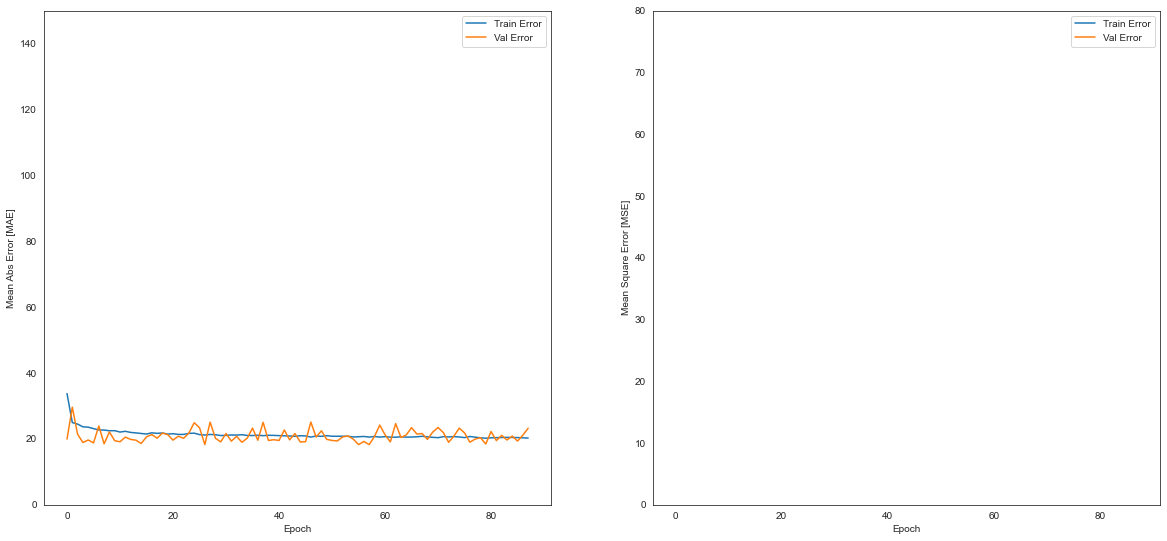

270/270 [==============================] - 0s 1ms/step - loss: 19.6742 - mae: 19.6742 - mse: 1568.8713
ulsan test set의 MAE: 19.674


In [210]:
model_ulsan, history_ulsan = train(final_dataset_dangjin, final_dataset_ulsan, 'ulsan')

Epoch 1/200
216/216 - 1s - loss: 65.9904 - mae: 65.9904 - mse: 19378.4062 - val_loss: 47.6202 - val_mae: 47.6202 - val_mse: 9048.6133
Epoch 2/200
216/216 - 1s - loss: 49.2372 - mae: 49.2372 - mse: 9589.7500 - val_loss: 41.1593 - val_mae: 41.1593 - val_mse: 7295.9355
Epoch 3/200
216/216 - 1s - loss: 47.5130 - mae: 47.5130 - mse: 9125.5762 - val_loss: 41.0187 - val_mae: 41.0187 - val_mse: 7640.2505
Epoch 4/200
216/216 - 0s - loss: 47.5850 - mae: 47.5850 - mse: 9137.1436 - val_loss: 42.1884 - val_mae: 42.1884 - val_mse: 7204.6001
Epoch 5/200
216/216 - 1s - loss: 46.6869 - mae: 46.6869 - mse: 8790.9102 - val_loss: 38.2411 - val_mae: 38.2411 - val_mse: 6729.8672
Epoch 6/200
216/216 - 0s - loss: 45.2793 - mae: 45.2793 - mse: 8312.4678 - val_loss: 38.3403 - val_mae: 38.3403 - val_mse: 7027.2178
Epoch 7/200
216/216 - 1s - loss: 44.4989 - mae: 44.4989 - mse: 8065.6626 - val_loss: 37.3369 - val_mae: 37.3369 - val_mse: 6500.6777
Epoch 8/200
216/216 - 0s - loss: 44.8174 - mae: 44.8174 - mse: 8192.

Epoch 00062: early stopping


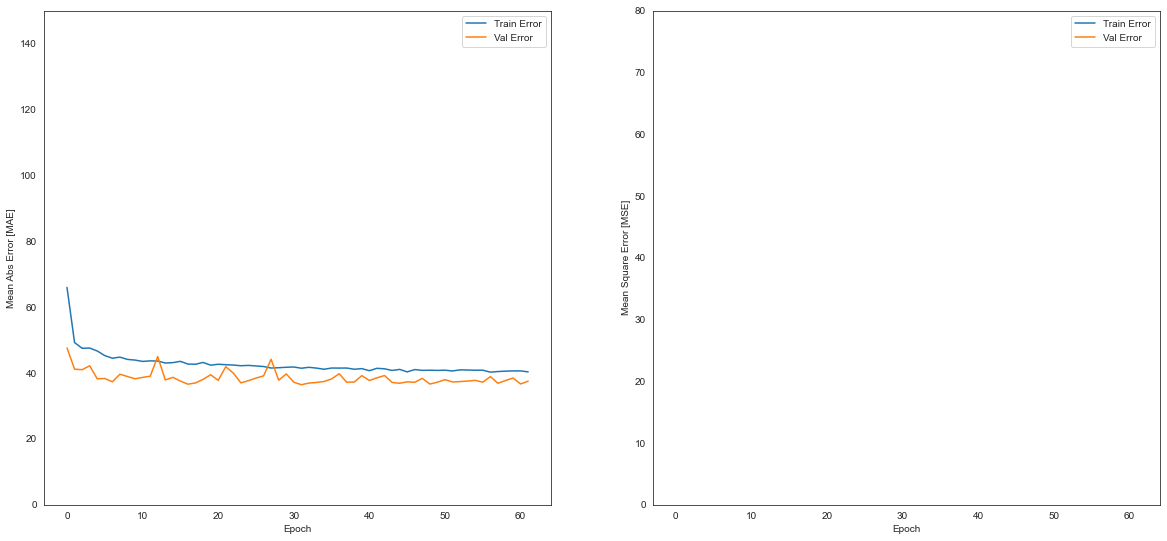

270/270 [==============================] - 0s 952us/step - loss: 38.2249 - mae: 38.2249 - mse: 7519.8696
dangjin test set의 MAE: 38.225
Epoch 1/200
216/216 - 1s - loss: 47.2817 - mae: 47.2817 - mse: 9919.8887 - val_loss: 23.8859 - val_mae: 23.8859 - val_mse: 2621.1665
Epoch 2/200
216/216 - 0s - loss: 34.8201 - mae: 34.8201 - mse: 4977.9507 - val_loss: 23.0599 - val_mae: 23.0599 - val_mse: 2506.4167
Epoch 3/200
216/216 - 0s - loss: 33.1730 - mae: 33.1730 - mse: 4556.5762 - val_loss: 24.2881 - val_mae: 24.2881 - val_mse: 2568.0864
Epoch 4/200
216/216 - 1s - loss: 32.6879 - mae: 32.6879 - mse: 4494.1069 - val_loss: 22.1548 - val_mae: 22.1548 - val_mse: 2519.9148
Epoch 5/200
216/216 - 0s - loss: 32.0361 - mae: 32.0361 - mse: 4434.8823 - val_loss: 28.2232 - val_mae: 28.2232 - val_mse: 3663.1030
Epoch 6/200
216/216 - 0s - loss: 31.2370 - mae: 31.2370 - mse: 4205.2612 - val_loss: 24.3776 - val_mae: 24.3776 - val_mse: 2572.1091
Epoch 7/200
216/216 - 0s - loss: 31.7173 - mae: 31.7173 - mse: 4268

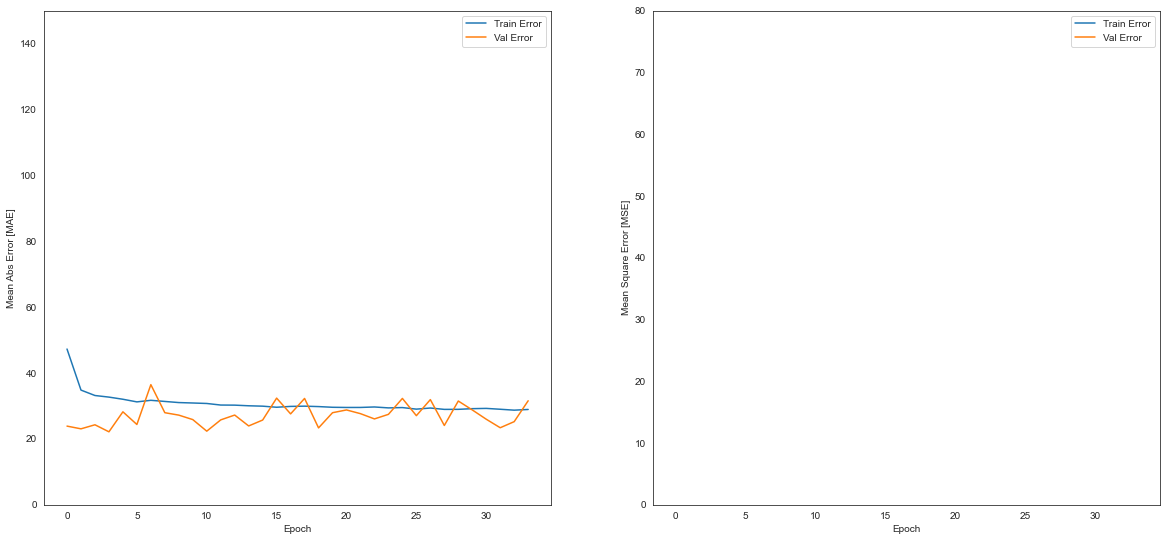

270/270 [==============================] - 0s 1ms/step - loss: 29.6329 - mae: 29.6329 - mse: 4266.1196
dangjin_warehouse test set의 MAE: 29.633
Epoch 1/200
216/216 - 1s - loss: 64.6432 - mae: 64.6432 - mse: 18115.6934 - val_loss: 32.2283 - val_mae: 32.2283 - val_mse: 4474.6108
Epoch 2/200
216/216 - 0s - loss: 45.7473 - mae: 45.7473 - mse: 8294.1240 - val_loss: 30.5232 - val_mae: 30.5232 - val_mse: 4234.4380
Epoch 3/200
216/216 - 0s - loss: 45.0517 - mae: 45.0517 - mse: 8110.0723 - val_loss: 40.5277 - val_mae: 40.5277 - val_mse: 6428.0708
Epoch 4/200
216/216 - 0s - loss: 43.7014 - mae: 43.7014 - mse: 7779.7881 - val_loss: 29.1867 - val_mae: 29.1867 - val_mse: 4068.5527
Epoch 5/200
216/216 - 0s - loss: 42.9164 - mae: 42.9164 - mse: 7629.7705 - val_loss: 30.1063 - val_mae: 30.1063 - val_mse: 4297.6665
Epoch 6/200
216/216 - 0s - loss: 42.9082 - mae: 42.9082 - mse: 7591.4312 - val_loss: 30.8546 - val_mae: 30.8546 - val_mse: 4627.2490
Epoch 7/200
216/216 - 0s - loss: 41.9562 - mae: 41.9562 - 

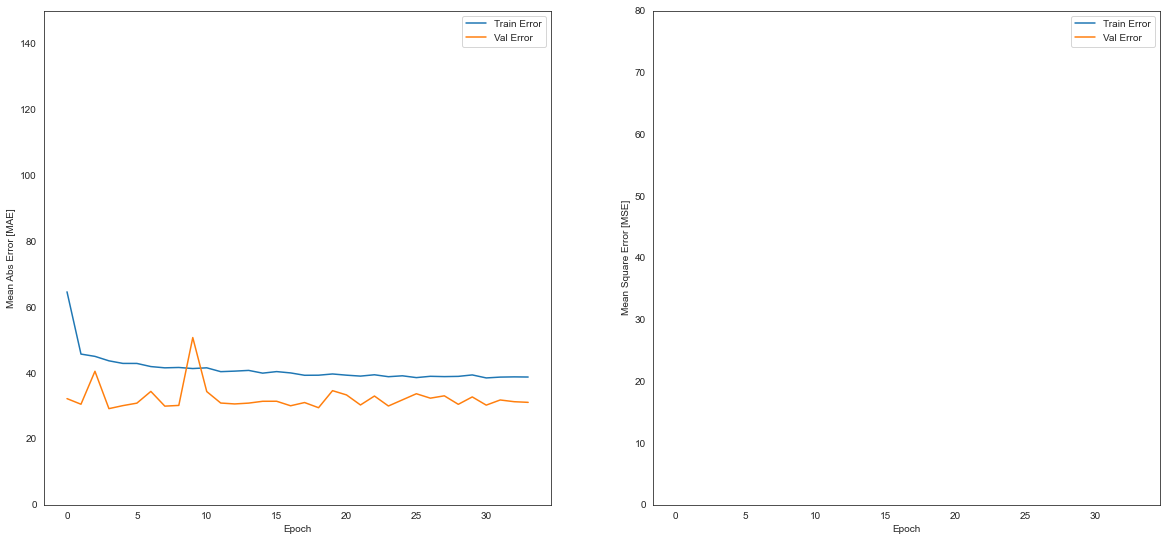

270/270 [==============================] - 0s 1ms/step - loss: 36.8510 - mae: 36.8510 - mse: 7038.2964
dangjin_floating test set의 MAE: 36.851


In [354]:
(model_dangjin, model_warehouse, model_floating, 
history_dangjin, history_warehouse, history_floating) = train(final_dataset_dangjin, final_dataset_ulsan, 'dangjin')

# 3. 평가 및 제출

In [359]:
x_train, x_test, y_train, y_test = train_test_split(final_dataset_dangjin[dangjin_bound:dangjin_end][['cos(time)',
                                                                     'GHI',
                                                                     'Temperature',
                                                                     'Humidity',
                                                                     'Wind_x',
                                                                     'Wind_y']], 
                                                                final_dataset_dangjin[dangjin_bound:dangjin_end]['dangjin_floating'],
                                                                test_size=0.2, shuffle=False)

In [358]:
x_train_ulsan, x_test_ulsan, y_train_ulsan, y_test_ulsan = train_test_split(
                    final_dataset_ulsan[ulsan_bound:ulsan_end][['cos(time)',
                                                                     'GHI',
                                                                     'Temperature',
                                                                     'Humidity',
                                                                     'Wind_x',
                                                                     'Wind_y']], 
                                                                final_dataset_ulsan[ulsan_bound:ulsan_end]['ulsan'],
                                                                test_size=0.2, shuffle=False)

In [355]:
def Evaluate_NMAE(answer_df, submission_df):
    sum_submission = np.array(submission_df.iloc[:,0:].sum(axis=1))
    sum_answer = np.array(answer_df.values.sum(axis=1))
    absolute_error = np.abs(sum_answer-sum_submission)
    absolute_error /= 3200
    target_idx = pd.DataFrame(sum_answer[sum_answer>=3200*0.1]).index
    nmae = 100 * absolute_error[target_idx].mean()
    return nmae

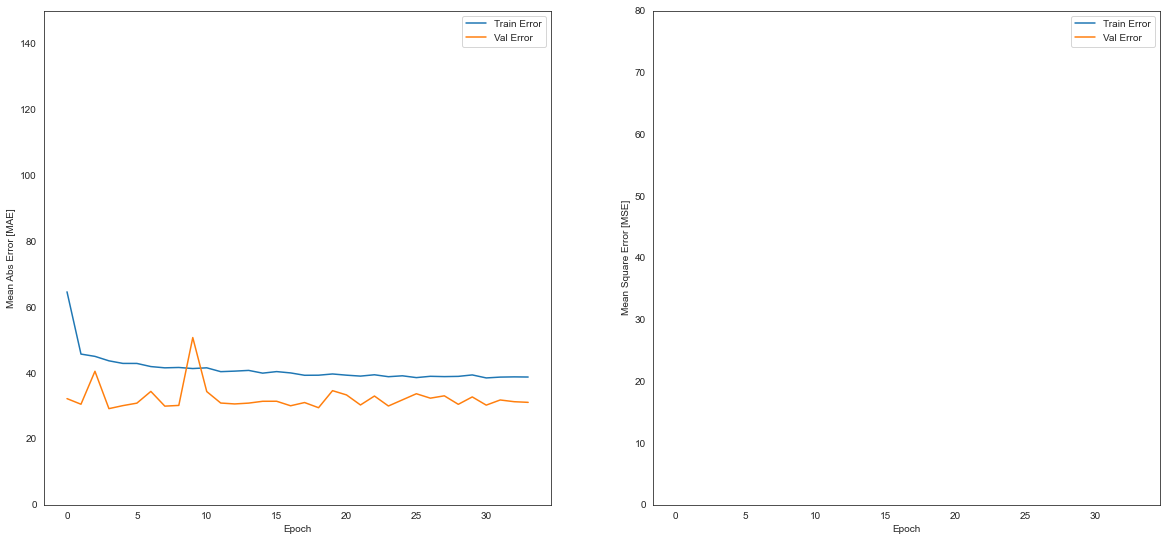

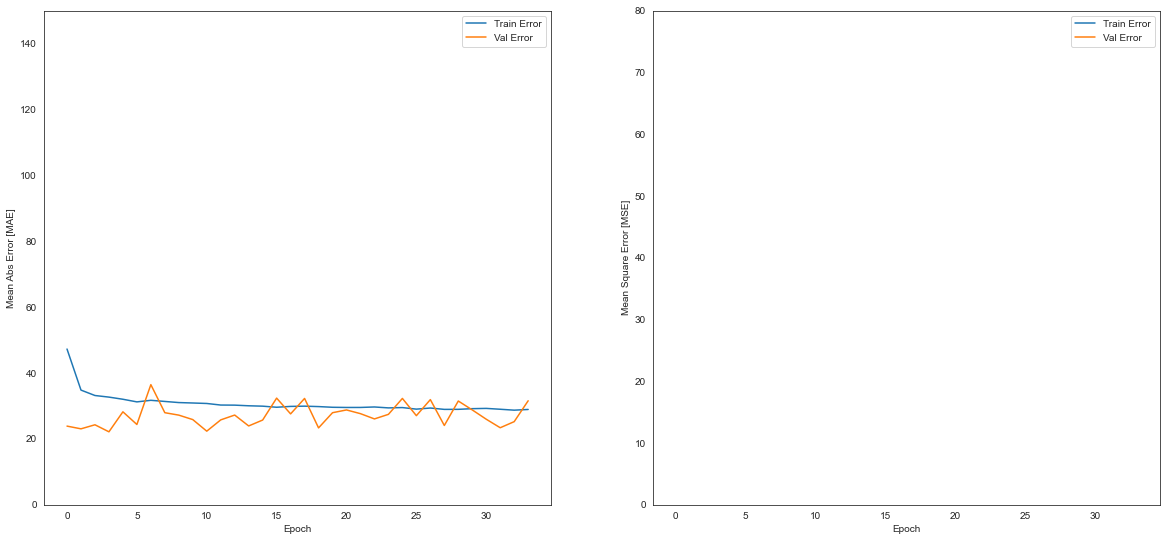

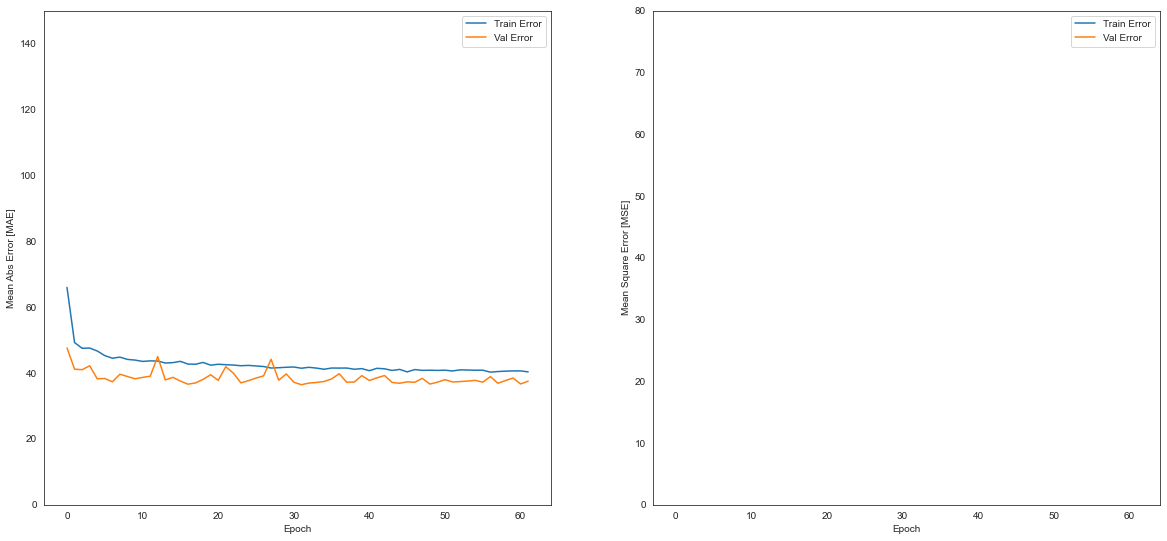

55/55 [==============================] - 0s 1ms/step - loss: 31.5501 - mae: 31.5501 - mse: 4290.9565
울산 제외 3개 장소 최종 submission 의 MAE: 31.550
NMAE for MLP : 2.6967116660910415


In [356]:
#=====================15~19 4개년 데이터로 20년 전체 예측============================#
plot_history(history_floating)
plot_history(history_warehouse)
plot_history(history_dangjin)
loss1, mae1, mse1 = model_floating.evaluate(x_test, y_test, verbose=1)
print("%s 의 MAE: %.3f"%('울산 제외 3개 장소 최종 submission',mae1))

answer_floating = final_dataset_dangjin[dangjin_bound:dangjin_end]['dangjin_floating']
answer_warehouse = final_dataset_dangjin[dangjin_bound:dangjin_end]['dangjin_warehouse']
answer_dangjin = final_dataset_dangjin[dangjin_bound:dangjin_end]['dangjin']
answer_ulsan = final_dataset_ulsan[ulsan_bound:ulsan_end]['ulsan']

test_period = final_dataset_dangjin[dangjin_bound:dangjin_end][['cos(time)',
                                                                 'GHI',
                                                                 'Temperature',
                                                                 'Humidity',
                                                                 'Wind_x',
                                                                 'Wind_y']]

submission_floating = pd.DataFrame(np.squeeze(model_floating.predict(test_period)))
submission_warehouse = pd.DataFrame(np.squeeze(model_warehouse.predict(test_period)))
submission_dangjin = pd.DataFrame(np.squeeze(model_dangjin.predict(test_period)))
submission_ulsan = pd.DataFrame(np.squeeze(model_ulsan.predict(test_period)))

answer_df = pd.concat([answer_dangjin, 
                       answer_warehouse, 
                       answer_floating,
                       answer_ulsan], axis=1).reset_index().drop('index', axis=1)
submission_df = pd.concat([submission_dangjin, 
                           submission_warehouse, 
                           submission_floating,
                           submission_ulsan], axis=1)
print("NMAE for MLP :",Evaluate_NMAE(pd.DataFrame(answer_df), pd.DataFrame(submission_df)))

In [357]:
#========================== 15~19년 만 가지고1 21년 2월 예측 
#========================== 15~20년까지 포함하면 어떻게 될 지 모름
start = dangjin_end+31*24
end = dangjin_end+31*24+674
answer_floating = final_dataset_dangjin[start:end]['dangjin_floating']
answer_warehouse = final_dataset_dangjin[start:end]['dangjin_warehouse']
answer_dangjin = final_dataset_dangjin[start:end]['dangjin']
answer_ulsan = final_dataset_ulsan[start:end]['ulsan']

test_period = final_dataset_dangjin[start:end][['cos(time)',
                                                 'GHI',
                                                 'Temperature',
                                                 'Humidity',
                                                 'Wind_x',
                                                 'Wind_y']]

submission_floating = pd.DataFrame(np.squeeze(model_floating.predict(test_period)))
submission_warehouse = pd.DataFrame(np.squeeze(model_warehouse.predict(test_period)))
submission_dangjin = pd.DataFrame(np.squeeze(model_dangjin.predict(test_period)))
submission_ulsan = pd.DataFrame(np.squeeze(model_ulsan.predict(test_period)))

answer_df = pd.concat([answer_dangjin, 
                       answer_warehouse, 
                       answer_floating,
                       answer_ulsan], axis=1).reset_index().drop('index', axis=1)
submission_df = pd.concat([submission_dangjin, 
                           submission_warehouse, 
                           submission_floating,
                           submission_ulsan], axis=1)
print("NMAE for MLP :",Evaluate_NMAE(pd.DataFrame(answer_df), pd.DataFrame(submission_df)))

NMAE for MLP : 1.899303451135172


* submission file 생성

In [360]:
s = np.where(raw_weather_dangjin['Time'] == '2021-02-01 0:00')[0][0]
e = np.where(raw_weather_dangjin['Time'] == '2021-03-01 0:00')[0][0]

time_axis = raw_weather_dangjin['Time'][s:e].reset_index().drop('index', axis=1)

In [361]:
new_submission = pd.concat([time_axis, submission_df],axis=1)
submission = new_submission[:672]
submission.columns = ['time', 'dangjin_floating', 'dangjin_warehouse','dangjin',"ulsan"]
final_submission = pd.concat([sample_submission['time'],final_submission.drop('time', axis=1)], axis=1)

In [365]:
final_submission.to_csv('210528_YJ_submission.csv', header=True, index=False)
final_submission

time  dangjin_floating  dangjin_warehouse   dangjin  \
0     2021-02-01 01:00:00           0.00032           0.000004  0.000229   
1     2021-02-01 02:00:00           0.00032           0.000004  0.000229   
2     2021-02-01 03:00:00           0.00032           0.000004  0.000229   
3     2021-02-01 04:00:00           0.00032           0.000004  0.000229   
4     2021-02-01 05:00:00           0.00032           0.000004  0.000229   
...                   ...               ...                ...       ...   
1387  2021-07-08 20:00:00           0.00000           0.000000  0.000000   
1388  2021-07-08 21:00:00           0.00000           0.000000  0.000000   
1389  2021-07-08 22:00:00           0.00000           0.000000  0.000000   
1390  2021-07-08 23:00:00           0.00000           0.000000  0.000000   
1391  2021-07-08 24:00:00           0.00000           0.000000  0.000000   

         ulsan  
0    -0.000196  
1    -0.000196  
2    -0.000196  
3    -0.000196  
4    -0.000196  
...        ...  
1387  0.000000  
1388  0.000000  
1389  0.000000  
1390  0.000000  
1391  0.000000  

[1392 rows x 5 columns]

## 부록. 머신러닝 기법 + 시각화 파트
* 여기도 코드 업데이트가 필요함

In [39]:
#=========SVM 회귀==========#
from sklearn.svm import SVR

#GHI_svm_reg = SVR(kernel = 'rbf',degree=3, C=1000, epsilon = 0.01, verbose = True)
#GHI_svm_reg.fit(x_train_dangjin, y_train_dangjin)

In [132]:
#=========XGBoost 회귀==========#
import xgboost
from xgboost import XGBRegressor
GHI_xgb_reg = XGBRegressor()
GHI_xgb_reg.fit(x_train_dangjin, y_train_dangjin.astype(float))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [133]:
import lightgbm
from lightgbm import LGBMRegressor
GHI_lgbm_reg = LGBMRegressor(boosting_type='gbdt',
                            num_leaves = 256,
                            max_depth = 9,
                            learning_rate = 0.05,
                            n_estimators=100)
GHI_lgbm_reg.fit(x_train_dangjin, y_train_dangjin.astype(float))

C:\Users\aai-pc-8\anaconda3\envs\DeepLearning\lib\site-packages\lightgbm\basic.py:154: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


LGBMRegressor(learning_rate=0.05, max_depth=9, num_leaves=256)

In [232]:
def Evaluate_NMAE_dangjin(answer_df, submission_df):
    sum_submission = np.array(submission_df.iloc[:,0:].sum(axis=1))
    sum_answer = np.array(answer_df.values.sum(axis=1))
    absolute_error = np.abs(sum_answer-sum_submission)
    absolute_error /= 1000
    target_idx = pd.DataFrame(sum_answer[sum_answer>=1000*0.1]).index
    nmae = 100 * absolute_error[target_idx].mean()

    return nmae

In [210]:
answer_dangjin = raw_power_dangjin[train_bound:]
answer_warehouse = raw_power_warehouse[train_bound:]
answer_ulsan = raw_power_ulsan[train_bound:]
dangjin_2021_01 = proc_data_dangjin[train_bound:]
warehouse_2021_01 = proc_data_dangjin[train_bound:]
ulsan_2021_01 = proc_data_ulsan[train_bound:]
MLP_submission_df = np.squeeze(model_dangjin.predict(dangjin_2021_01))
ware_submission_df = np.squeeze(model_warehouse.predict(warehouse_2021_01))
#MLP_submission_ulsan = np.squeeze(model_ulsan.predict((ulsan_2021_01)))
LGB_submission_df = np.squeeze(GHI_lgbm_reg.predict(dangjin_2021_01))
#SVM_submission_df = np.squeeze(GHI_svm_reg.predict(GHI_2021_01))
XGB_submission_df = np.squeeze(GHI_xgb_reg.predict(dangjin_2021_01))

C:\Users\aai-pc-8\anaconda3\envs\DeepLearning\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [211]:
print("NMAE for MLP :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(MLP_submission_df)))
print("NMAE, MLP, warehouse :",Evaluate_NMAE_ware(pd.DataFrame(answer_warehouse), pd.DataFrame(ware_submission_df)))

#print("NMAE for ULS :",Evaluate_NMAE(answer_ulsan, MLP_submission_ulsan))
print("NMAE for LGB :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(LGB_submission_df)))
#print("NMAE for SVM :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(SVM_submission_df)))
print("NMAE for XGB :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(XGB_submission_df)))

NMAE for MLP : 4.318632084217226
NMAE, MLP, warehouse : 8.054132769107982
NMAE for LGB : 5.8487756257097585
NMAE for XGB : 6.480300503433263


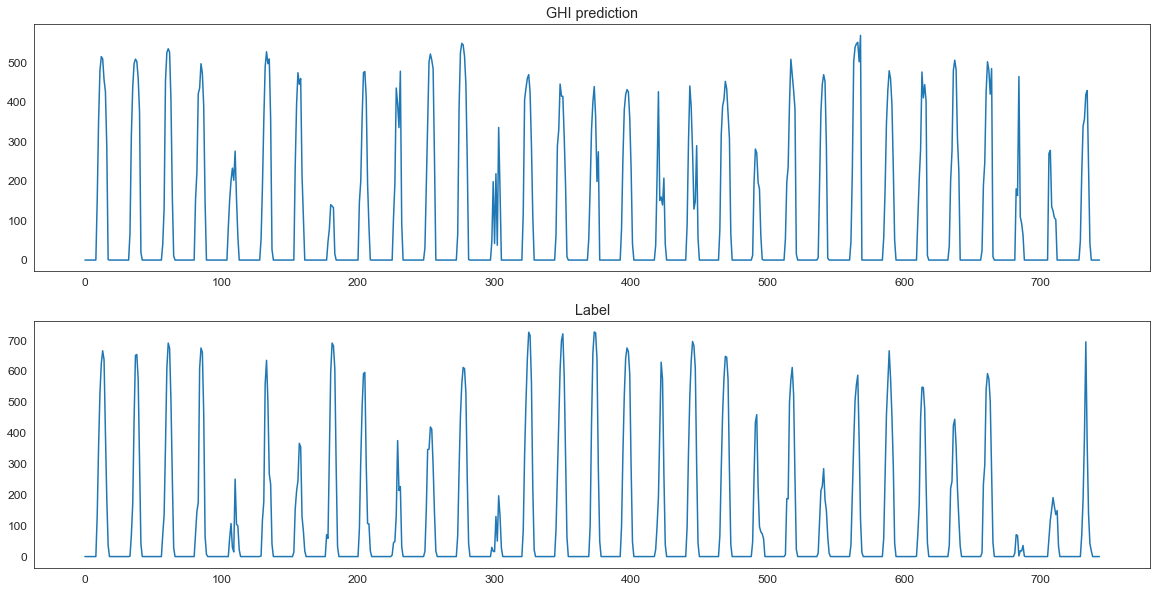

In [149]:
length = 25632-24888
fig = plt.figure(figsize=(20,10))
plt.rc('font', size = 12)
plt.subplot(211)
plt.title('GHI prediction')
plt.plot(range(0,len(dangjin_temp['cos(time)'][-length:])), 
         np.squeeze(model_dangjin.predict(dangjin_2021_01))[-length:])

plt.subplot(212)
plt.title('Label')
plt.plot(range(0,len(dangjin_temp['cos(time)'][-length:])), 
         raw_power_dangjin[-length:])

In [215]:
year = 24*365

In [223]:
np.where(answer_floating>)

(array([], dtype=int64),)

In [226]:
reset

index  dangjin_floating
0    54768               0.0
1    54769               0.0
2    54770               0.0
3    54771               0.0
4    54772               0.0
..     ...               ...
715  55483               0.0
716  55484               0.0
717  55485               0.0
718  55486               0.0
719  55487               0.0

[720 rows x 2 columns]

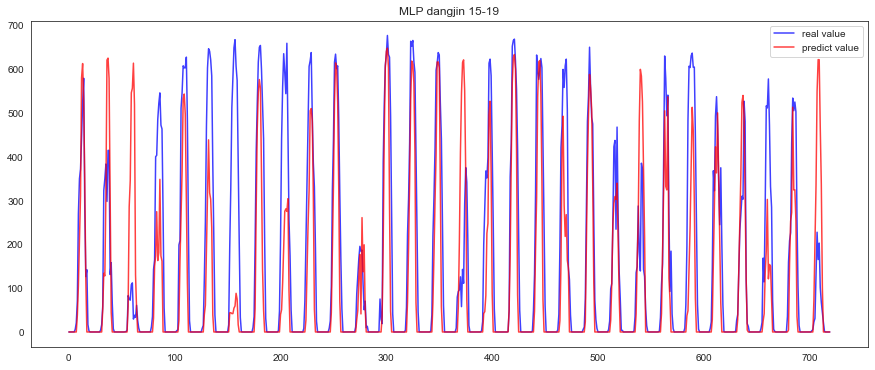

In [230]:
place = ['dangjin','dangjin_warehouse','dangjin_floating']
fig = plt.figure( figsize = (15, 6) )
chart = fig.add_subplot(1,1,1)
reset = final_dataset_dangjin[place[2]][-24*30:].reset_index()
chart.plot(reset[place[2]], marker='', color='blue', alpha = 0.75, label='real value')
chart.plot(np.squeeze(model_dangjin.predict(test_period))[-24*30:], marker='', color='red', alpha = 0.75, label='predict value')
chart.set_title('MLP dangjin 15-19')
plt.legend(loc = 'best') 

NameError: name 'answer_dangjin' is not defined

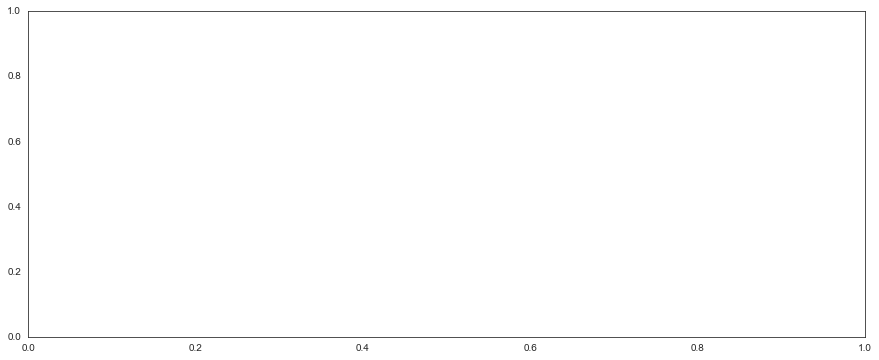

In [188]:
fig = plt.figure( figsize = (15, 6) )
chart = fig.add_subplot(1,1,1)
reset = final_dataset_dangjin['dangjin'][-24*365:].reset_index()
print("NMAE for MLP :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(submission_dangjin)))
chart.plot(reset['dangjin'], marker='', color='blue', alpha = 0.5, label='real value')
chart.plot(np.squeeze(model_dangjin.predict(test_period))[-year:], marker='', color='red', alpha = 0.5, label='predict value')
chart.set_title('MLP dangjin 15-19')
plt.legend(loc = 'best');

NMAE for LGBM : 5.8487756257097585


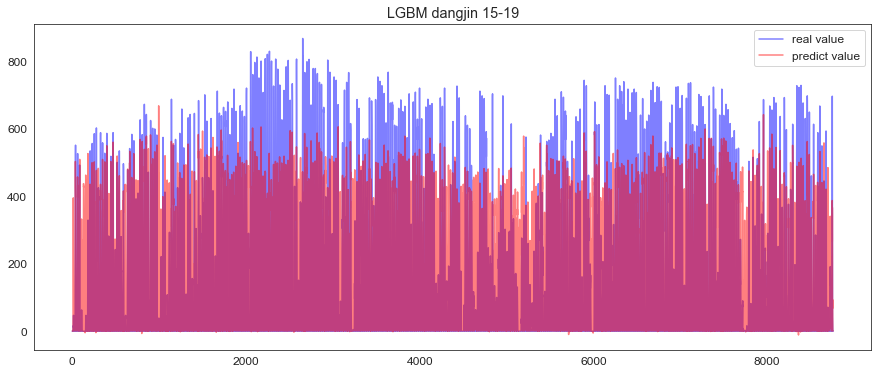

In [232]:
fig = plt.figure( figsize = (15, 6) )
chart = fig.add_subplot(1,1,1)
reset = raw_power_dangjin[-year:].reset_index()
print("NMAE for LGBM :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(LGB_submission_df)))
chart.plot(reset['dangjin'], marker='', color='blue', alpha = 0.5, label='real value')
chart.plot(np.squeeze(GHI_lgbm_reg.predict(dangjin_2021_01))[-year:], marker='', color='red', alpha = 0.50,
                                                                   label='predict value')
chart.set_title('LGBM dangjin 15-19')
plt.legend(loc = 'best');

NMAE for XGBoost : 6.480300503433263


C:\Users\aai-pc-8\anaconda3\envs\DeepLearning\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


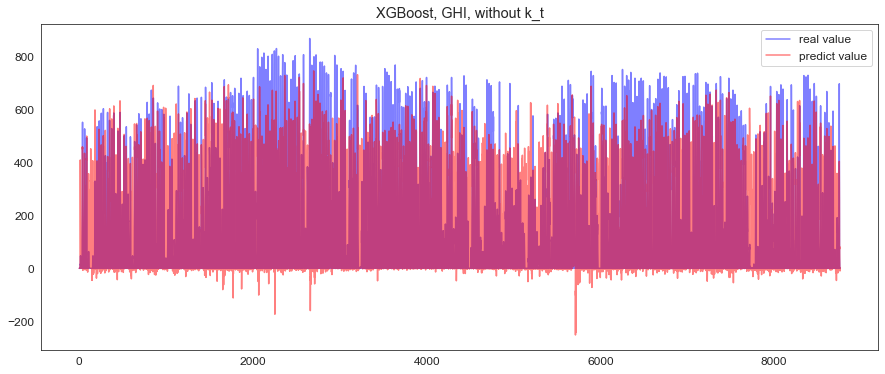

In [227]:
fig = plt.figure( figsize = (15, 6) )
chart = fig.add_subplot(1,1,1)
reset = raw_power_dangjin[-year:].reset_index()
print("NMAE for XGBoost :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(XGB_submission_df)))
chart.plot(reset['dangjin'], marker='', color='blue', alpha = 0.5, label='real value')
chart.plot(np.squeeze(GHI_xgb_reg.predict(dangjin_2021_01))[-year:], marker='', color='red', alpha = 0.5, label='predict value')
chart.set_title('XGBoost, GHI, without k_t')
plt.legend(loc = 'best')

In [ ]:
fig = plt.figure(figsize = (20, 10))
plt.subplot(211)
sns.lineplot(data=data_dangjin, x= data_dangjin.index, y = 'Power', linewidth = 0.2)

In [289]:
reset['Power']

0      0
1      0
2      0
3      0
4      0
      ..
739    0
740    0
741    0
742    0
743    0
Name: Power, Length: 744, dtype: int64